# Equity Indexes and ETFs

In [ ]:
import pandas as pd
import numpy as np
import datetime
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import seaborn as sns

import sys
sys.path.insert(0, '..')
from utils import *
from portfolio import *

***

# Indexes

## The S&P 500

### Constituents

The S&P 500 is composed of 
- US-listed public equities
- Large market cap
- Liquid shares
- A few extra conditions on financials to try to eliminate excess turnover

For practical purposes, consider it as the largest 500 U.S. equities.

Reference: S&P Index methodology, pgs 6-10

https://www.spglobal.com/spdji/en/documents/methodologies/methodology-sp-us-indices.pdf?utm_source=pdf_brochure

In [ ]:
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

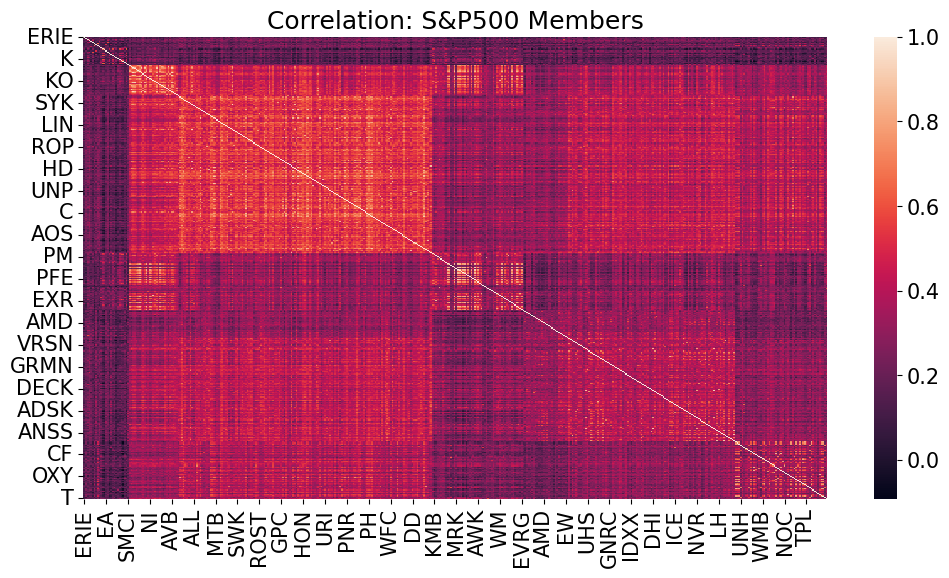

In [ ]:
ALTFILE = "../data/spx_returns_weekly.xlsx"
FREQ = 52
rets_spx = pd.read_excel(ALTFILE, sheet_name="s&p500 rets").set_index("date")

sns.heatmap(cluster_corr(rets_spx.corr()))
plt.title('Correlation: S&P500 Members')
plt.show()

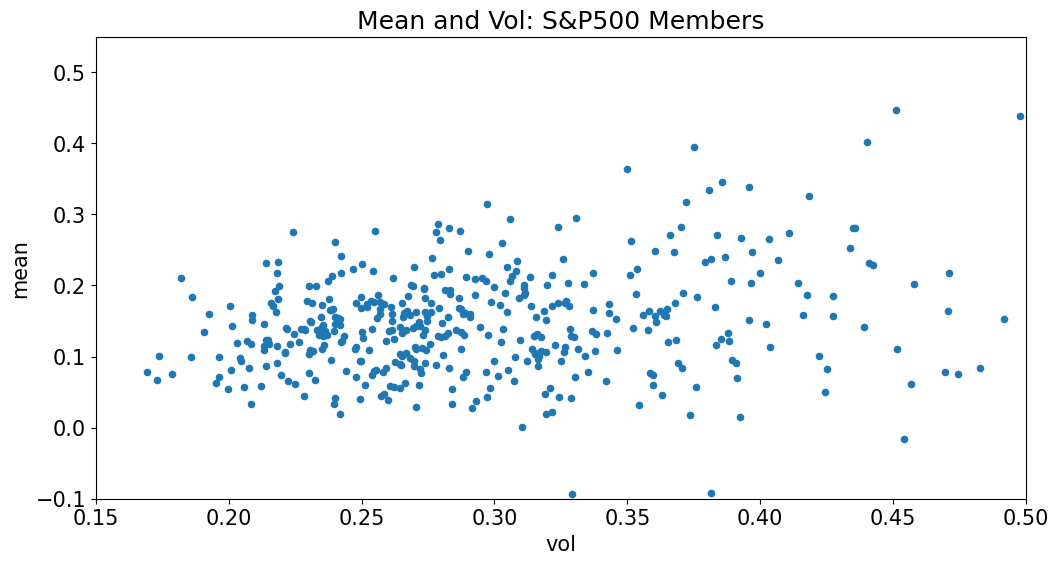

In [ ]:
temp = pd.concat([rets_spx.mean()*FREQ, rets_spx.std()*FREQ**.5],axis=1)
temp.columns=['mean','vol']
temp.plot.scatter(x='vol',y='mean',xlim=(.15,.5),ylim=(-.1,.55));
plt.title('Mean and Vol: S&P500 Members');

### There is an outlier over this period

The outlier is ENPH 
- joined the S&P 500 at the end of 2020
- energy firm
- volatile and high-trending returns

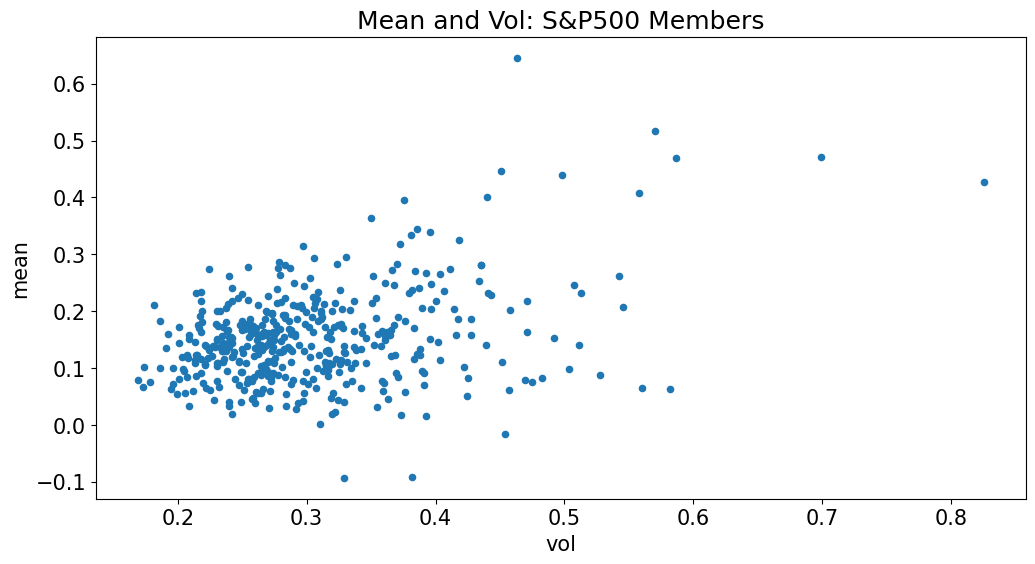

In [ ]:
temp.plot.scatter(x='vol',y='mean');
plt.title('Mean and Vol: S&P500 Members');

## Additional U.S. Equity Indexes

Other U.S. equity indexes include many from the S&P:
- S&P 100 - mega cap
- S&P 1500 - large and medium cap
- S&P Sector Indexes

Also consider
- Russell 1000
- Russell 2000
- Wilshire 5000

### Dow Jones Industrial
In financial news, you will often see reference to the Dow Jones Industrial Average (DJIA)
- You will rarely (if ever) use this
- Prominent for historical reasons, but not a good choice for most applications/analysis

Problems with using it include
- Index of only 30 "prominent" equities. 
- Weighting is by price, not by market cap. 
- Turnover may be too slow.

**The DJIA is highly correlated to the S&P500, which is probably the only info of use to us in the index.**

## Exchange-based Indexes

An important set of indexes are those that include stocks trading on a particular **exchange**.

* NYSE Composite (New York)
* NASDAQ Composite (New York)
* FTSE 100 (London)
* Nikkei 225 (Tokyo)
* DAX (German)
* Hang Seng (Hong Kong)

### Additional International Equity Indexes

MSCI indexes provide a wide number of indexes based on global regions and other global designations.

## Style Indexes

There are numerous style indexes used as benchmarks for various types of equity trading strategies.

By far, these indexes focus on
* small vs large (size)
* value vs growth (style)

### Fama-French Factors

The Fama-French Factors serve as popular indexes for these styles.
- Particularly for historical research

Source: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

In [ ]:
index_info = pd.read_excel(INFILE,sheet_name='index info').set_index('ticker')
index_info

name  count_index_members
ticker                                               
SPX                S&P 500 INDEX                  503
NYA         NYSE COMPOSITE INDEX                 1855
CCMP            NASDAQ COMPOSITE                 3271
RIY           RUSSELL 1000 INDEX                 1003
RTY           RUSSELL 2000 INDEX                 1930
INDU        DOW JONES INDUS. AVG                   30
DJITR   DJ INDUSTRIAL AVERAGE TR                   30
NKY                   NIKKEI 225                  225
HSI              HANG SENG INDEX                   85
UKX               FTSE 100 INDEX                  100
DAX                    DAX INDEX                   40
SVX                S&P 500 Value                  399
SGX               S&P 500 Growth                  211

In [ ]:
cols_international = ['NKY','HSI','UKX','DAX']
cols_forward = ['NKY','HSI']

indexes = pd.read_excel(INFILE,sheet_name=f'index history').set_index('date')
rets_index = indexes.pct_change().dropna()
rets_index = pd.concat([rets_index.drop(columns=cols_international),rets_index[cols_international]],axis=1)
rets_index[cols_forward] = rets_index[cols_forward].shift(-1)

/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_40635/1249175068.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets_index = indexes.pct_change().dropna()


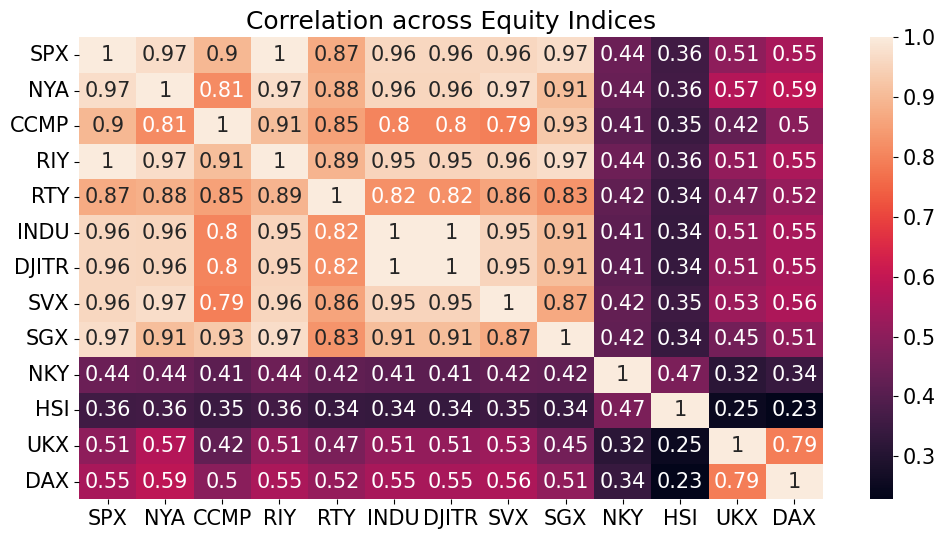

In [ ]:
sns.heatmap(rets_index.corr(),annot=True);
plt.title('Correlation across Equity Indices');

***

# Exchange-Traded Funds

:::::{grid} 2
:::{card} 
**[Investors Pile Into ETFs at Record Pace Despite Market Turmoil](https://www.wsj.com/finance/investing/etf-investing-records-81f8c51e)**  
WSJ - May 25, 2025  
U.S. exchange-traded funds have collected some $437 billion in new assets so far this year.
:::


:::{card} 
**[What's Left to be ETF'd?](https://www.wsj.com/finance/investing/new-etfs-whats-left-37a0705c)**
WSJ - Sep 13, 2024
There’s an ETF for nearly everything, but good ones are rare.
:::


:::{card} 
**[ETFs Are Flush With New Money. Why Billions More Are Flowing Their Way](https://www.wsj.com/finance/investing/etfs-are-flush-with-new-money-why-billions-more-are-flowing-their-way-8d9cbfb7)**  
WSJ - Oct 1, 2025  
Investors have plowed more than $900 billion into U.S. exchange-traded funds so far this year
:::

:::{card} 
**[Where the New ETF Money Is Going](https://www.wsj.com/livecoverage/stock-market-today-government-shutdown-10-01-2025/card/where-the-new-etf-money-is-going-3viM9CDAgBr2YLGyWESN)**
WSJ - Oct 1, 2025
Top net ETF inflows year-to-date
:::

:::::

An **exchange-traded-fund**
* Trades on a stock exchange
* Shares of the fund which may hold a variety of assets
* Can be traded intra-day

### Questions
* What is an ETF?
* How does an ETF compare to Mutual Funds? 
* Why trade ETF’s?

### History
ETFs Began trading in the U.S. in 1993.
* Active-ETF’s approved in 2008.
* Around 2,000 ETF’s trade in U.S. markets.

### Variety
ETFs include funds
* passively tracking an index of equities
* actively tracking an equity style or trading strategy (smart beta)
* alternative assets

Most ETF’s track an index. ie. S&P 500, U.S. Treasury rate, BBB-AAA credit spread, etc.
* Target wide variety of equity sectors and geographies.
* Funds for a variety of asset classes: equities, oil, grains, credit instruments, etc.
* Active ETF’s tracking a strategy.

Note that the fund expenses and liquidity vary considerably across ETFs.

Consider a few examples.

In [ ]:
etf_info = pd.read_excel(INFILE,sheet_name=f'etf info').set_index('ticker')
etf_info[['fund_expense_ratio','eqy_dvd_yld_ind']] /= 100
etf_info.style.format({'fund_expense_ratio':'{:.2%}','eqy_dvd_yld_ind':'{:.2%}'})

## Mutual Funds vs ETFs

ETF’s directly trade unit blocks of the assets, for authorized participants.
* Allows intra-day trading.
* No cash-management for redemption, load, fee, etc.
* No direct redemption means favorable capital-gains treatment.

Liquidity
* Reduce idiosyncratic risk.
* Exchange-traded (U.S.)
* Allow for wide variety of trading strategies.

### ETF Share Creation / Redemption

How does an ETF achieve exchange trading? Why doesn't it run into the same issues of a mutual fund?
* Authorized Participants and market-making
* Arbitrage to keep price near NAV

The Greyscale Bitcoin Trust

## Indexes vs ETFs

#### Timing
Above we saw low correlation between equity indexes in the U.S. versus Europe, partly due to asynchronous trading across time-zones.

Below, note that the correlation between SPY, VGK, and EWJ is much higher.

/var/folders/zx/3v_qt0957xzg3nqtnkv007d00000gn/T/ipykernel_40635/1376750157.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets_etf = etfs.pct_change().dropna()


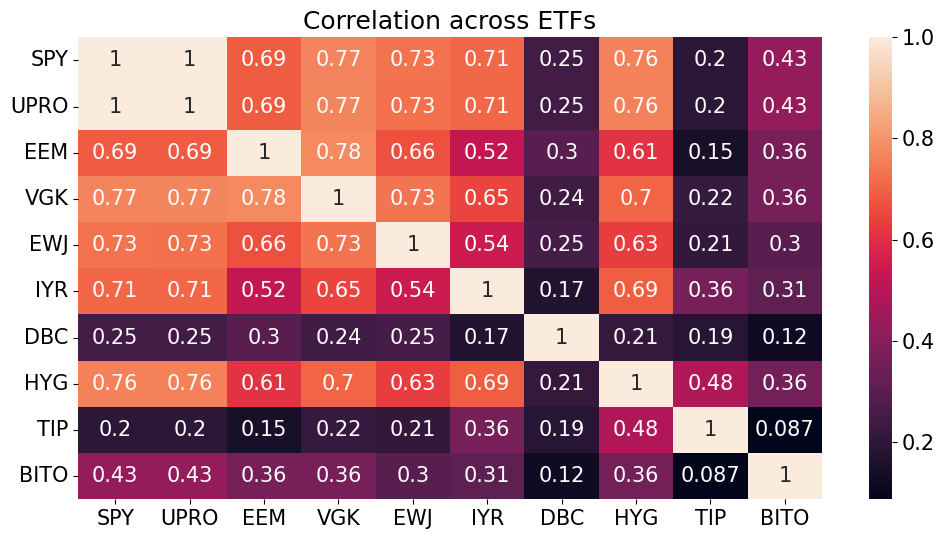

In [ ]:
etfs = pd.read_excel(INFILE,sheet_name=f'etf history').set_index('date')
rets_etf = etfs.pct_change().dropna()
sns.heatmap(rets_etf.corr(),annot=True);
plt.title('Correlation across ETFs');

### SPX vs SPY?

If we need a benchmark for a strategy, should we use SPX or SPY?

Why do they seem to have different return statistics below?

In [ ]:
spy_vs_spx = pd.concat([etfs[['SPY']],indexes[['SPX']]],axis=1).dropna().pct_change()
performanceMetrics(spy_vs_spx,annualization=252).style.format('{:.1%}')

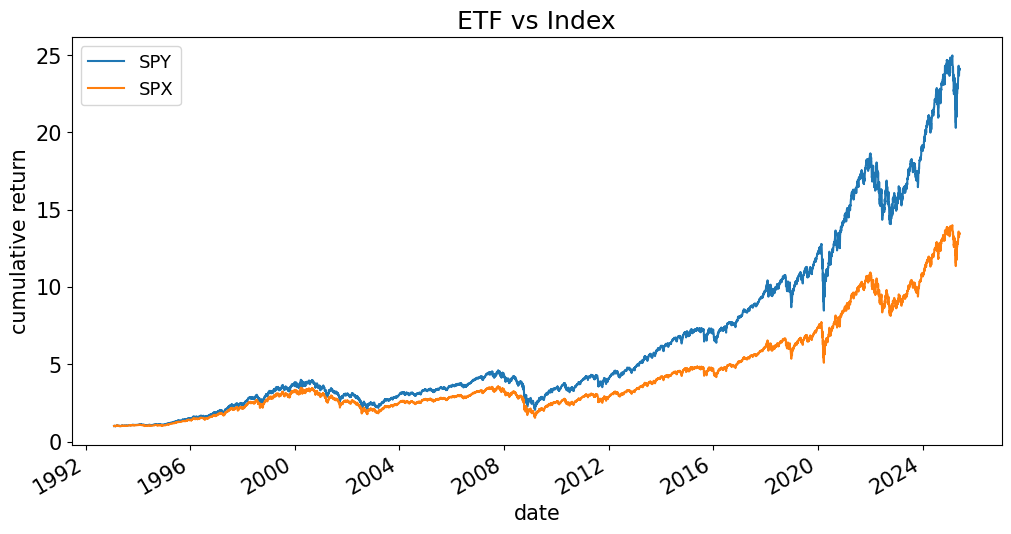

In [ ]:
(spy_vs_spx+1).cumprod().plot(title='ETF vs Index',ylabel='cumulative return');

## Levered ETFs

Levered ETFs seek to provide levered exposure to an index, such as the SPX.

These include inverse-levered ETFs.

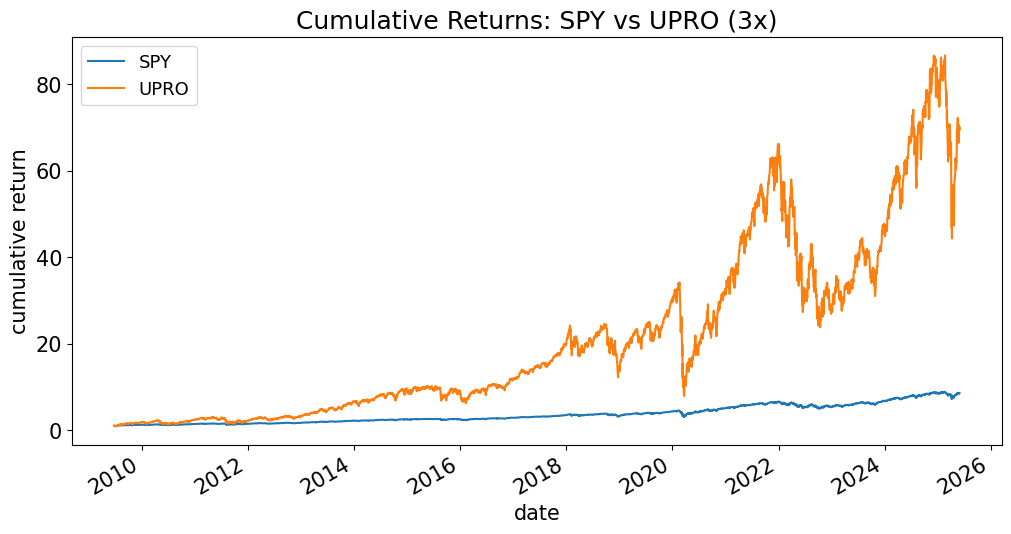

In [ ]:
spy_vs_letf = etfs[['SPY','UPRO']].dropna()

temp = (spy_vs_letf.pct_change()+1).cumprod()
temp.plot(title='Cumulative Returns: SPY vs UPRO (3x)',ylabel='cumulative return');

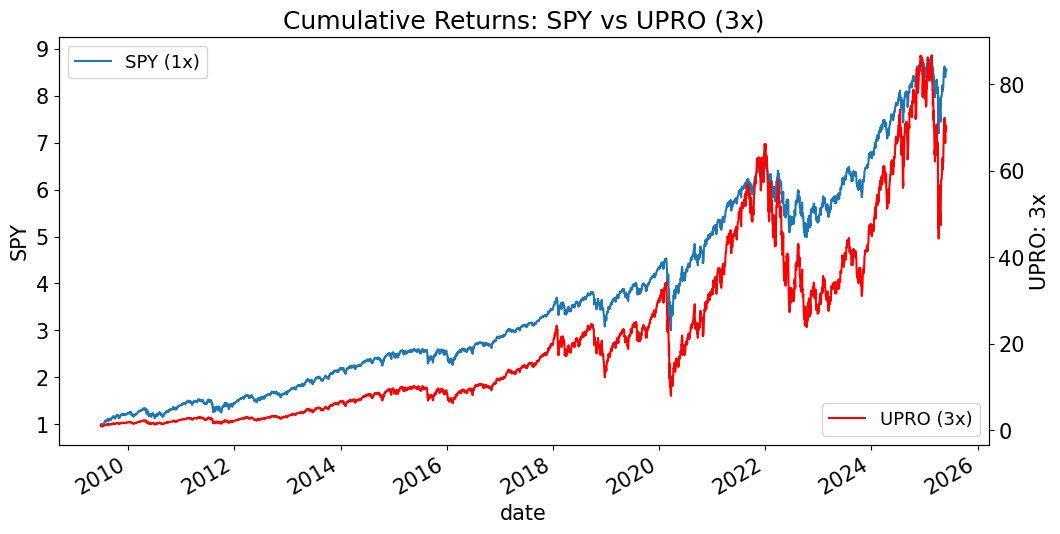

In [ ]:
fig, ax = plt.subplots()
temp[['SPY']].plot(ax=ax,ylabel='SPY');
ax.legend(['SPY (1x)'],loc='upper left')
ax2 = plt.twinx(ax=ax)
temp[['UPRO']].plot(ax=ax2,color='r',ylabel='UPRO: 3x');
ax2.legend(['UPRO (3x)'],loc='lower right');
plt.title('Cumulative Returns: SPY vs UPRO (3x)');

In [ ]:
performanceMetrics(spy_vs_letf.pct_change(),annualization=252).style.format('{:.1%}')

### More on LETFs

For more on the subtleties and dangers of Levered ETFs, see the extra notebook.